In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from math import fsum, sqrt
from scipy.stats import shapiro
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(7)

In [84]:
cars = pd.read_csv('car_data.csv', sep=',')
cars.head()

,Unnamed: 0,car_brand,car_model,car_price,car_city,car_fuel,car_transmission,car_drive,car_mileage,car_country,car_engine_capacity,car_engine_hp,car_age
0,0,Ford,Focus,550000,Astrakhan,gasoline,manual,FWD,300000,USA,1.8,125,14
1,1,Mercedes-Benz,GLA-Class,1820000,Astrakhan,gasoline,robot,FWD,88000,DE,1.6,156,10
2,2,Haval,F7,2600000,Astrakhan,gasoline,robot,4WD,19000,CN,1.5,150,2
3,3,Toyota,Camry,4200000,Astrakhan,gasoline,automatic,FWD,30000,JP,3.5,249,2
4,4,OMODA,C5,2125000,Astrakhan,gasoline,CVT,FWD,18824,CN,1.5,147,2


In [85]:
cars.drop(['Unnamed: 0'], axis=1, inplace=True)
cars.head()

,car_brand,car_model,car_price,car_city,car_fuel,car_transmission,car_drive,car_mileage,car_country,car_engine_capacity,car_engine_hp,car_age
0,Ford,Focus,550000,Astrakhan,gasoline,manual,FWD,300000,USA,1.8,125,14
1,Mercedes-Benz,GLA-Class,1820000,Astrakhan,gasoline,robot,FWD,88000,DE,1.6,156,10
2,Haval,F7,2600000,Astrakhan,gasoline,robot,4WD,19000,CN,1.5,150,2
3,Toyota,Camry,4200000,Astrakhan,gasoline,automatic,FWD,30000,JP,3.5,249,2
4,OMODA,C5,2125000,Astrakhan,gasoline,CVT,FWD,18824,CN,1.5,147,2


In [86]:
cars = cars.loc[cars['car_price'] < cars['car_price'].quantile(0.90)]
cars = cars.loc[cars['car_mileage'] < cars['car_mileage'].quantile(0.95)]

cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35981 entries, 0 to 42087
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_brand            35981 non-null  object 
 1   car_model            35981 non-null  object 
 2   car_price            35981 non-null  int64  
 3   car_city             35981 non-null  object 
 4   car_fuel             35981 non-null  object 
 5   car_transmission     35981 non-null  object 
 6   car_drive            35981 non-null  object 
 7   car_mileage          35981 non-null  int64  
 8   car_country          35981 non-null  object 
 9   car_engine_capacity  35981 non-null  float64
 10  car_engine_hp        35981 non-null  int64  
 11  car_age              35981 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 3.6+ MB


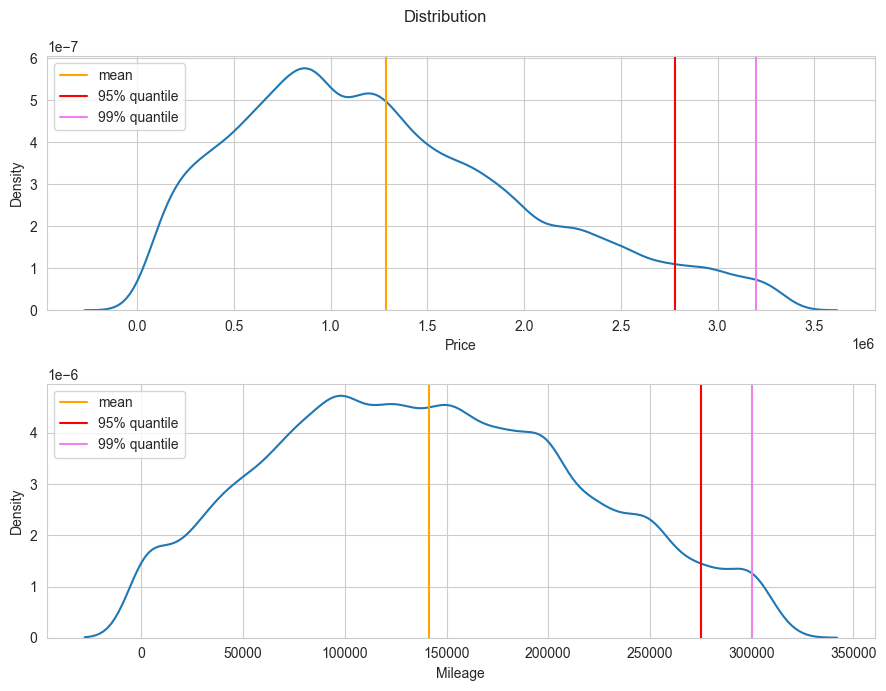

In [87]:
plt.figure(figsize=[9, 7])
plt.suptitle('Distribution')

plt.subplot(2, 1, 1)
sns.kdeplot(cars['car_price'])
plt.xlabel("Price")
plt.ylabel('Density')
plt.axvline(cars['car_price'].mean(), label='mean', c='orange')
plt.axvline(cars['car_price'].quantile(0.95), label='95% quantile', c='red')
plt.axvline(cars['car_price'].quantile(0.99), label='99% quantile', c='violet')
plt.legend()

plt.subplot(2, 1, 2)
sns.kdeplot(cars['car_mileage'])
plt.xlabel("Mileage")
plt.ylabel('Density')
plt.axvline(cars['car_mileage'].mean(), label='mean', c='orange')
plt.axvline(cars['car_mileage'].quantile(0.95), label='95% quantile', c='red')
plt.axvline(cars['car_mileage'].quantile(0.99), label='99% quantile', c='violet')
plt.legend()

plt.tight_layout()
plt.show()

In [88]:
X = cars.drop('car_price', axis=1)
y = cars['car_price']

y.head()

0     550000
1    1820000
2    2600000
4    2125000
6    2539000
Name: car_price, dtype: int64

In [89]:
X.head()

,car_brand,car_model,car_city,car_fuel,car_transmission,car_drive,car_mileage,car_country,car_engine_capacity,car_engine_hp,car_age
0,Ford,Focus,Astrakhan,gasoline,manual,FWD,300000,USA,1.8,125,14
1,Mercedes-Benz,GLA-Class,Astrakhan,gasoline,robot,FWD,88000,DE,1.6,156,10
2,Haval,F7,Astrakhan,gasoline,robot,4WD,19000,CN,1.5,150,2
4,OMODA,C5,Astrakhan,gasoline,CVT,FWD,18824,CN,1.5,147,2
6,Toyota,RAV4,Astrakhan,gasoline,CVT,FWD,68023,JP,2.0,146,9


In [90]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35981 entries, 0 to 42087
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_brand            35981 non-null  object 
 1   car_model            35981 non-null  object 
 2   car_city             35981 non-null  object 
 3   car_fuel             35981 non-null  object 
 4   car_transmission     35981 non-null  object 
 5   car_drive            35981 non-null  object 
 6   car_mileage          35981 non-null  int64  
 7   car_country          35981 non-null  object 
 8   car_engine_capacity  35981 non-null  float64
 9   car_engine_hp        35981 non-null  int64  
 10  car_age              35981 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 3.3+ MB


In [91]:
X = X[['car_mileage', 'car_age', 'car_engine_hp']]

X.head()

,car_mileage,car_age,car_engine_hp
0,300000,14,125
1,88000,10,156
2,19000,2,150
4,18824,2,147
6,68023,9,146


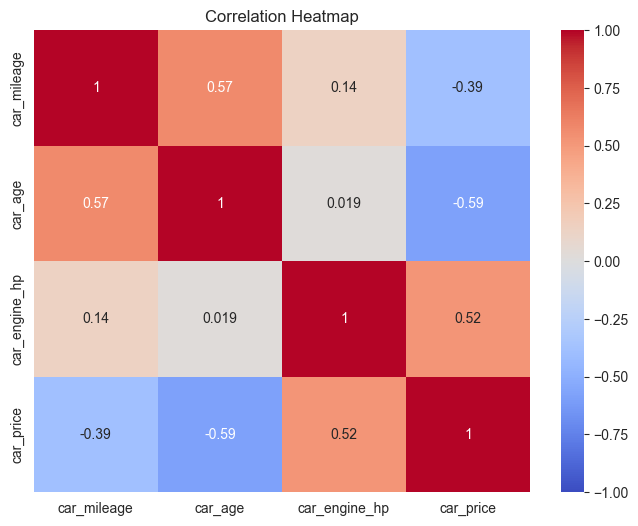

In [92]:
corr_matrix = pd.concat([X, y], axis=1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pd.concat([X_train, y_train], axis=1).head()

,car_mileage,car_age,car_engine_hp,car_price
8130,164500,8,129,930000
31336,120000,16,80,600000
34653,90000,20,249,679000
36132,209000,27,125,1150000
35879,200000,24,120,210000


In [94]:
model = RandomForestRegressor()
# model = DecisionTreeRegressor()
# lr = LinearRegression()
model.fit(X_train, y_train)

# print(lr.coef_)

RandomForestRegressor()

In [95]:
y_predict = model.predict(X_test)

print(y_predict)

[ 606165.73 2394069.9  2383953.2  ... 1246400.   2807827.1  1191390.53]


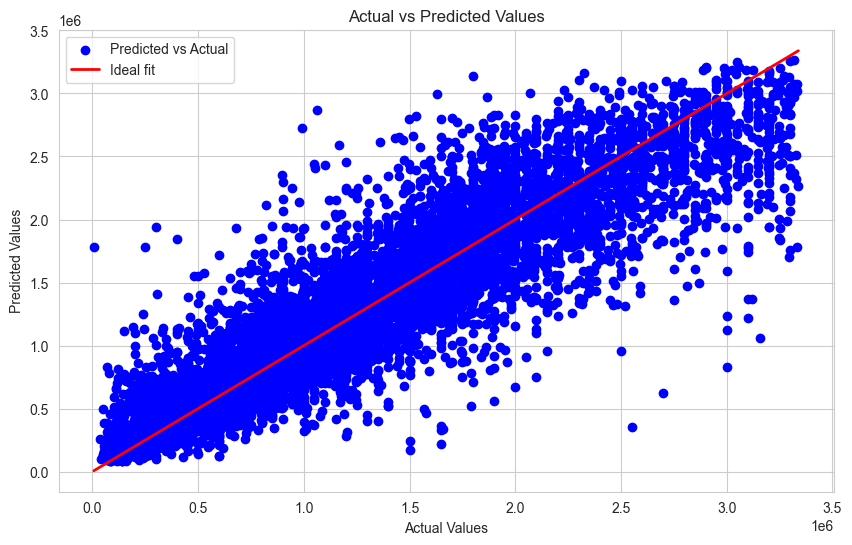

In [96]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Ideal fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

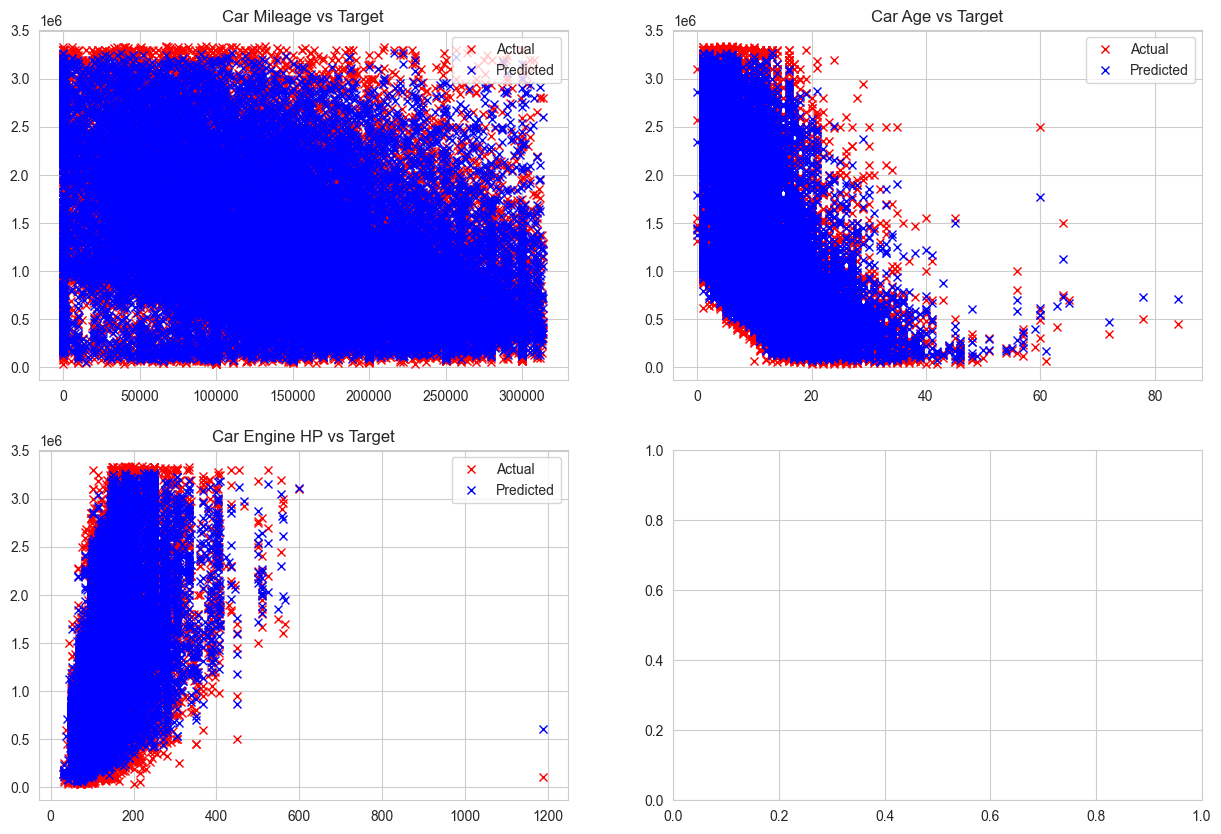

In [97]:
y_train_predict = model.predict(X_train)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Vẽ dữ liệu thực tế và đường dự đoán cho từng biểu đồ
axes[0,0].plot(X_train['car_mileage'], y_train, 'rx', label='Actual')
axes[0,0].plot(X_train['car_mileage'], y_train_predict, 'bx', label='Predicted')
axes[0,0].set_title('Car Mileage vs Target')
axes[0,0].legend()

axes[0,1].plot(X_train['car_age'], y_train, 'rx', label='Actual')
axes[0,1].plot(X_train['car_age'], y_train_predict, 'bx', label='Predicted')
axes[0,1].set_title('Car Age vs Target')
axes[0,1].legend()

axes[1,0].plot(X_train['car_engine_hp'], y_train, 'rx', label='Actual')
axes[1,0].plot(X_train['car_engine_hp'], y_train_predict, 'bx', label='Predicted')
axes[1,0].set_title('Car Engine HP vs Target')
axes[1,0].legend()

# Hiển thị biểu đồ
plt.show()

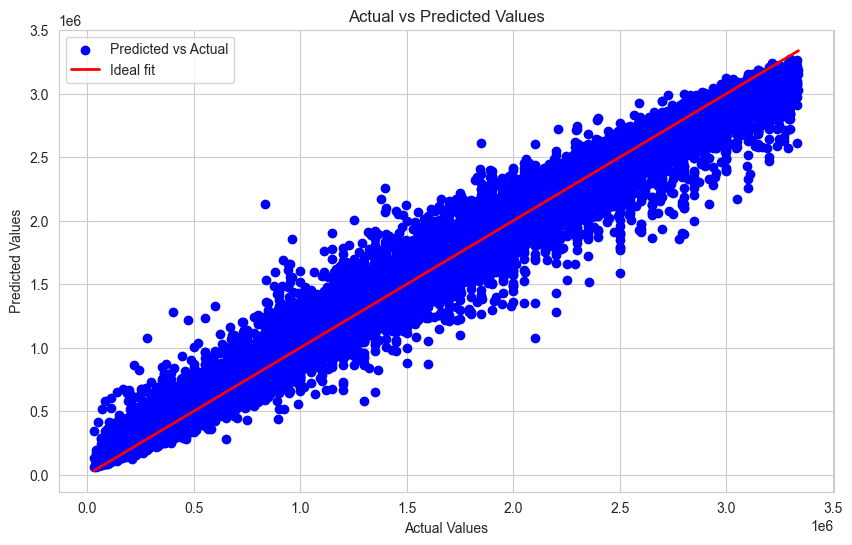

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_predict, color='blue', label='Predicted vs Actual')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linewidth=2, label='Ideal fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [99]:
r2 = sm.r2_score(y_test, y_predict)
mae = sm.mean_absolute_error(y_train, y_train_predict)
mse = sm.mean_squared_error(y_train, y_train_predict)
rmse = np.sqrt(mse)

# In các chỉ số đánh giá
print("R²: ", r2)
print("Mean Absolute Error (MAE): ", mae)
print("Mean Squared Error (MSE): ", mse)
print("Root Mean Squared Error (RMSE): ", rmse)

R²:  0.8096116435959344
Mean Absolute Error (MAE):  89361.62528558618
Mean Squared Error (MSE):  17274951183.927113
Root Mean Squared Error (RMSE):  131434.20857572474


In [100]:
import joblib

model.feature_names = ['car_mileage', 'car_age', 'car_engine_hp']
joblib.dump(model, "D:/STD/Python/fastApiProject/model.pkl")

['D:/STD/Python/fastApiProject/model.pkl']

In [101]:
model_backup = joblib.load("D:/STD/Python/fastApiProject/model.pkl")

model_backup.predict([[1,2,3]])

array([1628590.])

In [102]:
dfTest = pd.DataFrame({
    "car_mileage": [1],
    "car_age": [2],
    "car_engine_hp": [3]
})

model_backup.predict(dfTest)

array([1628590.])